In [1]:
%matplotlib inline

# Pytorch 数值套件教程

当它工作时，量化是好的，但很难知道什么是错误的，当它不满足我们期望的准确性。量化精度问题的调试并不容易，且耗时较长。

调试的一个重要步骤是度量浮点模型及其相应量化模型的统计量，以了解它们的最大差异在哪里。PyTorch 量化中构建了一套名为 PyTorch Numeric Suite 的数值工具，以支持量化模块和浮点模块之间的统计量的度量，从而支持量化调试工作。即使对于精度较高的量化模型，PyTorch Numeric Suite 仍然可以作为剖析工具，更好地理解模型内部的量化误差，并为进一步优化提供指导。

PyTorch Numeric Suite 目前支持通过统一的 API 的静态量化和动态量化来量化模型。

在本教程中，首先使用 ResNet18 作为一个例子来展示如何使用 PyTorch Numeric Suite 来度量静态量化模型和浮点模型之间的统计信息。然后将以基于 LSTM 的序列模型为例，展示 PyTorch Numeric Suite 在动态量化模型中的应用。


## 数值套件之静态量化

```{rubric} 设置
```

从必要的导入开始：

In [2]:
from __future__ import print_function, division, absolute_import
# import numpy as np
import torch
import torch.nn as nn
import torchvision
# from torchvision import datasets
# import torchvision.transforms as transforms
# import os
import torch.quantization
import torch.quantization._numeric_suite as ns
from torch.quantization import (
    default_eval_fn,
    default_qconfig,
    quantize,
)

然后加载预训练的浮点 ResNet18 模型，将其量化为 `qmodel`。我们不能比较两个任意的模型，只能比较一个浮点模型和它派生的量化模型。

In [4]:
float_model = torchvision.models.quantization.resnet18(pretrained=True,
                                                       quantize=False)
float_model.to('cpu')
float_model.eval()
float_model.fuse_model()
float_model.qconfig = default_qconfig
img_data = [(torch.rand(2, 3, 10, 10, dtype=torch.float),
             torch.randint(0, 1, (2,), dtype=torch.long)) for _ in range(2)]
qmodel = quantize(float_model, default_eval_fn, [img_data], inplace=False)

### 1. 比较浮点模型和量化模型的权重

首先要比较的是量化模型和浮点模型的权值。可以从 PyTorch Numeric Suite 调用 ``compare_weights()`` 来获得字典 ``wt_compare_dict``，其键对应于模块名，每个条目都是一个字典，有两个键 `'float'` 和 `'quantized'`，包含 float 和 quantized 权重。``compare_weights()`` 接受浮点和量化状态字典并返回一个字典，与浮点权值对应的键和值是浮点和量化权值的字典：

In [5]:
wt_compare_dict = ns.compare_weights(float_model.state_dict(),
                                     qmodel.state_dict())

print('`wt_compare_dict` 键：')
print(wt_compare_dict.keys())

print("\n`wt_compare_dict` 条目中 conv1 的权值：")
print(wt_compare_dict['conv1.weight'].keys())
print(wt_compare_dict['conv1.weight']['float'].shape)
print(wt_compare_dict['conv1.weight']['quantized'].shape)

`wt_compare_dict` 键：
dict_keys(['conv1.weight', 'layer1.0.conv1.weight', 'layer1.0.conv2.weight', 'layer1.1.conv1.weight', 'layer1.1.conv2.weight', 'layer2.0.conv1.weight', 'layer2.0.conv2.weight', 'layer2.0.downsample.0.weight', 'layer2.1.conv1.weight', 'layer2.1.conv2.weight', 'layer3.0.conv1.weight', 'layer3.0.conv2.weight', 'layer3.0.downsample.0.weight', 'layer3.1.conv1.weight', 'layer3.1.conv2.weight', 'layer4.0.conv1.weight', 'layer4.0.conv2.weight', 'layer4.0.downsample.0.weight', 'layer4.1.conv1.weight', 'layer4.1.conv2.weight', 'fc._packed_params._packed_params'])

`wt_compare_dict` 条目中 conv1 的权值：
dict_keys(['float', 'quantized'])
torch.Size([64, 3, 7, 7])
torch.Size([64, 3, 7, 7])


一旦获得 ``wt_compare_dict``，用户就可以以任何他们想要的方式处理这个字典。以 float 和量化模型权值的量化误差为例，计算如下。

计算量化张量 ``y`` 的信噪比（Signal-to-Quantization-Noise Ratio，简称 SQNR），它反映了最大标称（nominal）信号强度与量化中引入的量化误差之间的关系。更高的 SQNR 对应更低的量化误差。

In [6]:
def compute_error(x, y):
    Ps = torch.norm(x)
    Pn = torch.norm(x-y)
    return 20*torch.log10(Ps/Pn)


for key in wt_compare_dict:
    print(key,
          compute_error(wt_compare_dict[key]['float'],
                        wt_compare_dict[key]['quantized'].dequantize()))

conv1.weight tensor(31.6638)
layer1.0.conv1.weight tensor(30.6450)
layer1.0.conv2.weight tensor(31.1528)
layer1.1.conv1.weight tensor(32.1438)
layer1.1.conv2.weight tensor(31.2477)
layer2.0.conv1.weight tensor(30.9890)
layer2.0.conv2.weight tensor(28.8233)
layer2.0.downsample.0.weight tensor(31.5558)
layer2.1.conv1.weight tensor(30.7668)
layer2.1.conv2.weight tensor(28.4516)
layer3.0.conv1.weight tensor(30.9247)
layer3.0.conv2.weight tensor(26.6841)
layer3.0.downsample.0.weight tensor(28.7825)
layer3.1.conv1.weight tensor(28.9707)
layer3.1.conv2.weight tensor(25.6785)
layer4.0.conv1.weight tensor(26.8496)
layer4.0.conv2.weight tensor(25.8396)
layer4.0.downsample.0.weight tensor(28.6355)
layer4.1.conv1.weight tensor(26.8759)
layer4.1.conv2.weight tensor(28.4319)
fc._packed_params._packed_params tensor(32.6506)


另一个例子 ``wt_compare_dict`` 也可以用来绘制浮点和量化模型的权值直方图。

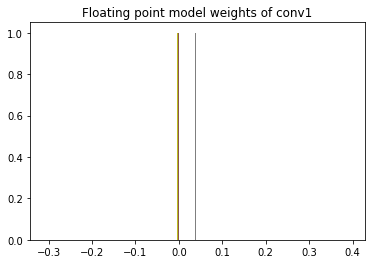

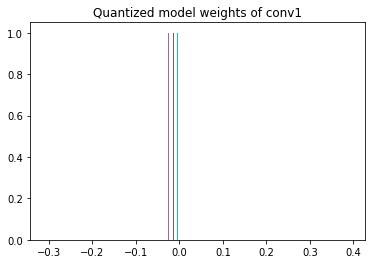

In [7]:
from matplotlib import pyplot as plt

f = wt_compare_dict['conv1.weight']['float'].flatten()
plt.hist(f, bins = 100)
plt.title("Floating point model weights of conv1")
plt.show()

q = wt_compare_dict['conv1.weight']['quantized'].flatten().dequantize()
plt.hist(q, bins = 100)
plt.title("Quantized model weights of conv1")
plt.show()

### 2. 比较浮点和量化模型在相应的位置

第二个工具允许对相同输入在相应位置上的浮点模型和量化模型之间的权重和激活进行比较，如下图所示。红色箭头表示比较的位置。

```{figure} images/compare_output.png
```

我们从 PyTorch Numeric Suite 调用 ``compare_model_outputs()`` 来获取给定输入数据对应位置的浮点模型和量化模型中的激活。这个 API 返回一个字典，其中模块名为键。每个条目本身是一个字典，有两个包含激活的键 'float' 和 'quantized'。

In [ ]:
data = img_data[0][0]

# 接受浮点和量化模型以及输入数据，并返回一个字典，其键对应于量化模块名称，
# 每个条目是一个字典，有两个键'float'和'quantized'，包含匹配位置上的浮点和量化模型的激活。
act_compare_dict = ns.compare_model_outputs(float_model, qmodel, data)

print('keys of act_compare_dict:')
print(act_compare_dict.keys())

print("\nkeys of act_compare_dict entry for conv1's output:")
print(act_compare_dict['conv1.stats'].keys())
print(act_compare_dict['conv1.stats']['float'][0].shape)
print(act_compare_dict['conv1.stats']['quantized'][0].shape)

该字典可用于比较和计算 float 和量化模型激活的量化误差，如下所示。

In [ ]:
for key in act_compare_dict:
    print(key,
          compute_error(act_compare_dict[key]['float'][0],
                        act_compare_dict[key]['quantized'][0].dequantize()))

如果希望对多个输入数据进行比较，可以执行以下操作。通过将 logger 附加到浮点模块和量化模块（如果它们在 ``white_list`` 中）来准备模型。默认的 logger 为 ``OutputLogger``，默认的 ``white_list`` 为 ``DEFAULT_NUMERIC_SUITE_COMPARE_MODEL_OUTPUT_WHITE_LIST``。

In [ ]:
ns.prepare_model_outputs(float_model, qmodel)

for data in img_data:
    float_model(data[0])
    qmodel(data[0])

# 查找浮点和量化模块之间的匹配激活，并返回一个字典，其键对应于量化模块名称，
# 每个条目是一个字典，有两个键'float'和'quantized'，包含由记录器记录的匹配浮点和量化激活
act_compare_dict = ns.get_matching_activations(float_model, qmodel)

上述 API 中使用的默认 logger 是 ``OutputLogger``，用于 log 模块的输出。我们可以继承基类 ``Logger``，并创建自己的 logger 来执行不同的功能。例如，我们可以创建一个新的 ``MyOutputLogger`` 类，如下所示。

In [ ]:
class MyOutputLogger(ns.Logger):
    r"""Customized logger class
    """

    def __init__(self):
        super(MyOutputLogger, self).__init__()

    def forward(self, x):
        # Custom functionalities
        # ...
        return x

然后我们可以把这个记录器传递到上面的 API 中，比如：

In [ ]:
data = img_data[0][0]
act_compare_dict = ns.compare_model_outputs(float_model,
                                            qmodel, data,
                                            logger_cls=MyOutputLogger)


或者：

In [ ]:
ns.prepare_model_outputs(float_model, qmodel, MyOutputLogger)
for data in img_data:
    float_model(data[0])
    qmodel(data[0])
act_compare_dict = ns.get_matching_activations(float_model, qmodel)

### 3. 使用相同的输入数据，将量化模型中的模块与等效的浮点模块进行比较

第三个工具允许比较模型中的量化模块和对应的浮点模块，为它们提供相同的输入，并比较它们的输出，如下所示。

```{figure} images/compare_stub.png
```

在实践中，我们调用 `prepare_model_with_stub()` 来交换我们想要比较的量化模块与 `Shadow` 模块，如下所示:

```{figure} images/shadow.png
```

``Shadow`` 模块以量化模块、浮点模块和 logger 作为输入，并在其中创建 forward 路径，使浮点模块与 shadow 量化模块共享同输入张量。

logger 可以自定义，默认的记录器是 ``ShadowLogger``，它将保存量化模块和浮点模块的输出，用于计算模块级量化误差。

注意，在每次调用 ``compare_model_outputs()`` 和 ``compare_model_stub()`` 之前，我们需要有干净的浮点和量化模型。这是因为 ``compare_model_outputs()`` 和 ``compare_model_stub()`` 对 float 和量化模型进行了原地修改，如果一个接一个地调用，将导致意想不到的结果。

In [ ]:
float_model = torchvision.models.quantization.resnet18(pretrained=True, quantize=False)
float_model.to('cpu')
float_model.eval()
float_model.fuse_model()
float_model.qconfig = torch.quantization.default_qconfig
img_data = [(torch.rand(2, 3, 10, 10, dtype=torch.float), torch.randint(0, 1, (2,), dtype=torch.long)) for _ in range(2)]
qmodel = quantize(float_model, default_eval_fn, [img_data], inplace=False)

在下面的例子中，我们调用 PyTorch 数值套件中的  ``compare_model_stub()`` 来比较 ``QuantizableBasicBlock`` 模块和它的浮点数等效值。这个 API 返回字典，其键对应于模块名，每个条目都是一个字典，有两个键 'float' 和 'quantized'，包含 quantized 及其匹配的浮点阴影模块的输出张量。

In [ ]:
data = img_data[0][0]
module_swap_list = [torchvision.models.quantization.resnet.QuantizableBasicBlock]

# Takes in floating point and quantized model as well as input data, and returns a dict with key
# corresponding to module names and each entry being a dictionary with two keys 'float' and
# 'quantized', containing the output tensors of quantized module and its matching floating point shadow module.
ob_dict = ns.compare_model_stub(float_model, qmodel, module_swap_list, data)

print('keys of ob_dict:')
print(ob_dict.keys())

print("\nkeys of ob_dict entry for layer1.0's output:")
print(ob_dict['layer1.0.stats'].keys())
print(ob_dict['layer1.0.stats']['float'][0].shape)
print(ob_dict['layer1.0.stats']['quantized'][0].shape)

这个字典可以用来比较和计算模块级量化误差。

In [ ]:
for key in ob_dict:
    print(key, compute_error(ob_dict[key]['float'][0], ob_dict[key]['quantized'][0].dequantize()))

如果希望对多个输入数据进行比较，可以执行以下操作。

In [ ]:
ns.prepare_model_with_stubs(float_model, qmodel, module_swap_list, ns.ShadowLogger)
for data in img_data:
    qmodel(data[0])
ob_dict = ns.get_logger_dict(qmodel)

在上述 API 中使用的默认记录器是 ``ShadowLogger``，用于记录量化模块及其匹配的浮动阴影模块的输出。我们可以继承基类 ``Logger``，并创建自己的 Logger 来执行不同的功能。例如，我们可以创建新的 ``MyShadowLogger`` 类，如下所示。

In [ ]:
class MyShadowLogger(ns.Logger):
    r"""Customized logger class
    """

    def __init__(self):
        super(MyShadowLogger, self).__init__()

    def forward(self, x, y):
        # Custom functionalities
        # ...
        return x

然后我们可以把这个记录器传递到上面的 API 中，比如：

In [ ]:
data = img_data[0][0]
ob_dict = ns.compare_model_stub(float_model, qmodel, module_swap_list, data, logger_cls=MyShadowLogger)

或者：

In [ ]:
ns.prepare_model_with_stubs(float_model, qmodel, module_swap_list, MyShadowLogger)
for data in img_data:
    qmodel(data[0])
ob_dict = ns.get_logger_dict(qmodel)

## Numeric Suite 之动态量化

Numeric Suite APIs are designed in such as way that they work for both dynamic quantized model and static quantized model. We will use a model with both LSTM and Linear modules to demonstrate the usage of Numeric Suite on dynamic quantized model. This model is the same one used in the tutorial of dynamic quantization on LSTM word language model [^1].

[^1]: [DYNAMIC QUANTIZATION ON AN LSTM WORD LANGUAGE MODEL](https://pytorch.org/tutorials/advanced/dynamic_quantization_tutorial.html).

### 设置

First we define the model as below. Notice that within this model only ``nn.LSTM`` and ``nn.Linear`` modules will be quantized dynamically and ``nn.Embedding`` will remain as floating point module after quantization.



In [ ]:
class LSTMModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken, ninp, nhid, nlayers, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        self.init_weights()

        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):
        emb = self.encoder(input)
        output, hidden = self.rnn(emb, hidden)
        decoded = self.decoder(output)
        return decoded, hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                weight.new_zeros(self.nlayers, bsz, self.nhid))

Then we create the ``float_model`` and quantize it into qmodel.



In [ ]:
ntokens = 10

float_model = LSTMModel(
    ntoken = ntokens,
    ninp = 512,
    nhid = 256,
    nlayers = 5,
)

float_model.eval()

qmodel = torch.quantization.quantize_dynamic(
    float_model, {nn.LSTM, nn.Linear}, dtype=torch.qint8
)

### 1. Compare the weights of float and quantized models

We first call ``compare_weights()`` from PyTorch Numeric Suite to get a dictionary ``wt_compare_dict`` with key corresponding to module names and each entry is a dictionary with two keys 'float' and 'quantized', containing the float and quantized weights.

In [ ]:
wt_compare_dict = ns.compare_weights(float_model.state_dict(), qmodel.state_dict())

Once we get ``wt_compare_dict``, it can be used to compare and compute the quantization error of the weights of float and quantized models as following.



In [ ]:
for key in wt_compare_dict:
    if wt_compare_dict[key]['quantized'].is_quantized:
        print(key, compute_error(wt_compare_dict[key]['float'], wt_compare_dict[key]['quantized'].dequantize()))
    else:
        print(key, compute_error(wt_compare_dict[key]['float'], wt_compare_dict[key]['quantized']))

The Inf value in ``encoder.weight`` entry above is because encoder module is not quantized and the weights are the same in both floating point and quantized models.

### 2. Compare float point and quantized models at corresponding locations

Then we call ``compare_model_outputs()`` from PyTorch Numeric Suite to get the activations in float model and quantized model at corresponding locations for the given input data. This API returns a dict with module names being keys. Each entry is itself a dict with two keys 'float' and 'quantized' containing the activations. Notice that this sequence model has two inputs, and we can pass both inputs into ``compare_model_outputs()`` and ``compare_model_stub()``.



In [ ]:
input_ = torch.randint(ntokens, (1, 1), dtype=torch.long)
hidden = float_model.init_hidden(1)

act_compare_dict = ns.compare_model_outputs(float_model, qmodel, input_, hidden)
print(act_compare_dict.keys())

This dict can be used to compare and compute the quantization error of the activations of float and quantized models as following. The LSTM module in this model has two outputs, in this example we compute the error of the first output.



In [ ]:
for key in act_compare_dict:
    print(key, compute_error(act_compare_dict[key]['float'][0][0], act_compare_dict[key]['quantized'][0][0]))

### 3. Compare a module in a quantized model with its float point equivalent, with the same input data

Next we call ``compare_model_stub()`` from PyTorch Numeric Suite to compare LSTM and Linear module with its float point equivalent. This API returns a dict with key corresponding to module names and each entry being a dictionary with two keys 'float' and 'quantized', containing the output tensors of quantized and its matching float shadow module.

We reset the model first.



In [ ]:
float_model = LSTMModel(
    ntoken = ntokens,
    ninp = 512,
    nhid = 256,
    nlayers = 5,
)
float_model.eval()

qmodel = torch.quantization.quantize_dynamic(
    float_model, {nn.LSTM, nn.Linear}, dtype=torch.qint8
)

Next we call ``compare_model_stub()`` from PyTorch Numeric Suite to compare LSTM and Linear module with its float point equivalent. This API returns a dict with key corresponding to module names and each entry being a dictionary with two keys 'float' and 'quantized', containing the output tensors of quantized and its matching float shadow module.



In [ ]:
module_swap_list = [nn.Linear, nn.LSTM]
ob_dict = ns.compare_model_stub(float_model, qmodel, module_swap_list, input_, hidden)
print(ob_dict.keys())

This dict can be then used to compare and compute the module level quantization error.



In [ ]:
for key in ob_dict:
    print(key, compute_error(ob_dict[key]['float'][0], ob_dict[key]['quantized'][0]))

40db 的 SQNR 是很高的，在这种情况下，我们在浮点和量化模型之间有很好的数值对齐。

## 结论

在本教程中，我们演示了如何使用 PyTorch Numeric Suite 来度量量化模型和浮点模型之间的统计数据，并使用用于静态量化和动态量化的统一 API 在即时模式下进行比较。
感谢你的阅读!一如既往，我们欢迎任何反馈，所以如果您有任何问题，请创建 [issue](https://github.com/pytorch/pytorch/issues)。